# Introduction

This notebook serves as an exploration of orbital debris modeling and an introduction to ODAP (Orbital Debris Analysis with Python). While ODAP is currently being refined and converted into a standalone module, you will be able to explore how the module functions and can be utilized in research throughout this notebook.

Initially, this project started from a personal curiosity about how orbital debris works, but later was the basis for a senior thesis written while attending the Harriet L. Wilkes Honors College. The purpose is to develop a modern open-source python implementation of the NASA Standard Breakup Model that others can use to research orbital debris.

Since this project is on going, please note that some functionality may not be working as expected as I continue to go through the process of optimizing and validating the implementations of the various components.

# Table of Contents
### 0. [Packages](#packages)
Covers the initial setup to enable the notebook to function correctly
### 1. [Data Source](#data-source)
Loading real world data from Two Line Elements to use as the foundation for the rest of the simulations
### 2. [Fragmentation Event Modeling](#fragmentation)
### 3. [Cloud Formation and Propagation](#cloud)
### 4. [Analysis](#second-bullet)


<a class="anchor" id="packages"></a>
<h1>0. Packages</h1>

For the purposes of this notebook I will be using a variety of other common modules such as NuMpy, pandas, and Plotly. As such, the below cell will import all necessary modules, as well as import various components from ODAP that will be useful.

In [1]:
# System lib.
import sys
import os
import re
import datetime as datetime
from importlib import reload

# 3rd party lib.
import numpy as np
import chart_studio.plotly as py
import plotly.graph_objects as go
import chart_studio

# User defined lib.
if not os.path.join(sys.path[0], "..") in sys.path:
    sys.path.insert(1, os.path.join(sys.path[0], ".."))

%matplotlib widget

## 0.1 Authenticate with Plotly

In [2]:
# Retreiving API Keys from OS
PLOTLY_API_KEY = os.environ.get("wK2Ilky4B7zHdcxvbtWV")
PLOTYLY_USERNAME = os.environ.get("rhumphreys2017")

# Log into chart studio for uploading plots
chart_studio.tools.set_credentials_file(
    username=PLOTYLY_USERNAME, api_key=PLOTLY_API_KEY
)

<a class="anchor" id="data-source"></a>
<h1>1. Data Source</h1>

To perform accurate simulations, it is essential to have some real-world satellite data as the starting point for modeling the fragmentation event. Therefore, this notebook is a file containing NORAD Two-Line Element Sets (TLE) acquired from [CelesTrak](https://celestrak.com/NORAD/elements/). The rest of this section involves importing said data and discussing how the TLE data structure functions.

<h3>1.1 Loading TLE Data</h3>

TLE's are standardized data structures that contain the orbital elements used to describe Earth-orbiting objects for a given point in time. Most importantly, they are used to determine where a given object will be at any given time. Thus, it is a valuable tool for analyzing potential orbital collisions as well as tracking orbital debris.

To acquire the most recent information about all objects being tracked in Earth orbit is recommended to download the latest TLE data from CelesTrak. This file comes in the form of a `.txt` file that first must be parsed to use while programming. While it is possible to manually parse all of the data from the TLEs using [Regular expression operations](https://docs.python.org/3/library/re.html), for this notebook, I will be utilizing the `skyfield` python module as it has the built-in functionality to handle this.

In [3]:
# Opening the .txt file
from odap.models.tle import TLE

with open("data/3le.txt") as f:
    txt = f.read()

# Using regular expression to perform basic parsing of the 3le.txt file
# Returns and array of arrays where each subarray contains three strings
# corresponding to each line of th TLE
tles_data = np.array([tle for tle in re.findall("(.*?)\n(.*?)\n(.*?)\n", txt)])

# Convert name line of TLE to correct format
tles_data[:, 0] = [name[2:] for name in tles_data[:, 0]]

tles = [TLE(lines[0], lines[1], lines[2]) for lines in tles_data]

<h3>1.2 Select orbital object for analysis</h3>

Now that we have an array containing Satellite objects, we can utilize NumPy to find a satellite that satisfies whatever criterion we are looking for. For example, we may want to simulate a fragmentation event for a satellite with a low semi-major axis or a high eccentricity. To keep things simple, I selected a satellite using the name assigned to it by NORAD.

In [4]:
from odap.models.satellite import Satellite

# Constructing an array that contains the names of all the satellites in our dataset
# Note: The name formatting of all satellites starts with "0 ",
#       thus we slice the String to cut the 0.
desigs = np.array([tle.int_desig for tle in tles])

# Search the name array for the index of desired satellite
i = np.argwhere(desigs == "93009A").flatten()[0]

# Retrieve that satellite object from the `satellites` array using the found index
tle = tles[i]

# # Compute the cartesian state vectors
sat = Satellite(tle)

<a class="anchor" id="fragmentation"></a>
# 2. Fragmentation Event Modeling

A satellite breakup model is a mathematical model used to describe the outcome of a satellite breakup due to an explosion or collision. A satellite breakup model should describe the size, area-to-mass (AM) ratio, and the ejection velocity of each fragment produced in the satellite breakup. The most easily accessible literature model is the [NASA Standard breakup model](https://www.sciencedirect.com/science/article/abs/pii/S0273117701004239). This model is implemented in ODAP in `generate_debris.py`.

In the following subsections, ODAP is utilized to simulate an explosion event and a collision event. Additionally, some information about how the NASA Standard Breakup Model works is provided. For additional information it is recomended to refer to ...

In [5]:
import numpy as np

from nasa_sbm.configuration import SimulationConfiguration
from nasa_sbm.model import BreakupModel

config = SimulationConfiguration("data/simulation_config.yaml")
sat.cartesian_state
sat.r *= 1e3  # NASA SBM uses m instead of km
sat.v *= 1e3  # NASA SBM uses m/s instead of km/s
event = BreakupModel(config, np.array([sat]))
debris = event.run()
sat.r /= 1e3  # NASA SBM uses m instead of km
sat.v /= 1e3  # NASA SBM uses m/s instead of km/s

## 2.2 Performing a Fragmentation Event

#### 2.1.4 Converting coordinates to Keplerian elements

In [6]:
import odap.coordinates as coords

# Currently python-sbm returns values in m and m/s, thus we need to convert them
rs = debris[:, 1, :] / 1e3  # km
vs = debris[:, 6, :] / 1e3  # km/s

# unit: [km^3 / s^2]
mu_Earth = 3.986004418e5

debris_keplerian_state = coords.rv2coe_many(mu_Earth, rs, vs)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


## 2.2 Ring Formation

In [77]:
from odap.propagators import OrbitPropagator, null_perts

# Cleanup states to remove any fragments that would deorbit, given no perturbations
a = debris_keplerian_state[:, 0]
e = debris_keplerian_state[:, 1]
masses = debris[:, 5, 0]
areas = debris[:, 4, 0]

# Prune debris that would deorbit giv
radius_earth = 6371.07103  # km
periapsis = a * (1 - e)
I = np.argwhere(periapsis > radius_earth)
debris_keplerian_state = np.squeeze(debris_keplerian_state[I, :])

# # Propagate orbit for a period of time
perts = null_perts()
perts["aero"] = True
perts["J2"] = True

# Define orbital periods
T = 2 * np.pi * np.sqrt(a**3 / mu_Earth)


op = OrbitPropagator(
    debris_keplerian_state,
    areas,
    masses,
    [0, 40 * np.ceil(max(T))],
    60 * 5,
    perts=perts,
)
states = op.propagate_orbit()

In [78]:
def states_to_cartesian(states):
    states_cartesian = np.empty((states.shape[0], 2, states.shape[1], 3))
    for i in range(states.shape[0]):
        states_cartesian[i, :, :, :] = coords.coe2rv_many(
            mu_Earth,
            states[i, :, 0],
            states[i, :, 1],
            states[i, :, 2],
            states[i, :, 3],
            states[i, :, 4],
            states[i, :, 5],
        )
    return states_cartesian


states_cartesian = states_to_cartesian(states)

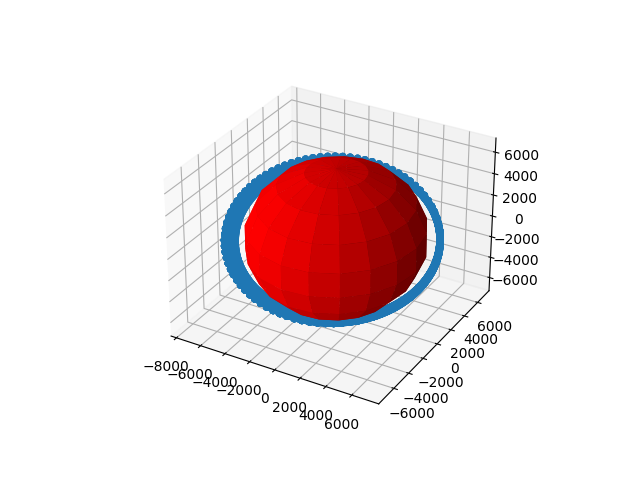

In [79]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.axes(projection="3d")

# Grabbing random pieces to visualize
I = np.random.randint(0, states_cartesian.shape[2], 5)

# Data for three-dimensional scattered points
zdata = states_cartesian[:, 0, I, 2]
xdata = states_cartesian[:, 0, I, 0]
ydata = states_cartesian[:, 0, I, 1]

# draw sphere
r_earth = 6371
u, v = np.mgrid[0 : 2 * np.pi : 20j, 0 : np.pi : 10j]
x = np.cos(u) * np.sin(v) * r_earth
y = np.sin(u) * np.sin(v) * r_earth
z = np.cos(v) * r_earth
ax.plot_surface(x, y, z, color="r")

ax.scatter3D(xdata, ydata, zdata);

<h4>3.4.2 Particle Debris flux</h4>

Using a particle flux to determine when the fragments of the debris have finished the formation of the ring. Indicating the end of the first phase of the debris cloud formation. This is accomplished by creating an xz plane and detecting when particles have switched from one side to the other. This approach will cause a peak as fragments pass through that becomes uniform as the debris becomes uniformly spread out.



In [83]:
import time
import matplotlib.dates as mdates
from dateutil import tz


def fragmentation_flux(X):
    return np.sum((X[:-1, :, 1] < 0) & (X[1:, :, 1] > 0), axis=1)


position = states_cartesian[:, 0, :, :]
flux = fragmentation_flux(position)

<h4>3.4.3 Convergence of the flux</h4>

The next step is determining when the fragments have ended the torroid formation phase. This occurs when the fragments are approximately uniformally spread out. We can check to see when the flux meets a convergence criterion to determine when this happens.

Now that the band has formed, we can shift away from propagating the exact position of each fragments and inplace propgate their changes in eccentricity and semi major axis due to drag. To do this first we must get the final states of the debris after the band has formed.

In [86]:
import datetime as datetime

w = 100  # Window of points to look at
tol = 1.5
convergence_ratio = np.array(
    [np.var(flux[i : i + w]) / np.mean(flux[i : i + w]) for i in range(len(flux))]
)
intersection_index = np.argwhere(convergence_ratio <= tol).flatten()[
    2
]  # Grabbing the second point that meets the criteria

# datetimes
t_flux = datetime.datetime.now() + np.array(range(len(flux))) * datetime.timedelta(
    minutes=5
)

# Removing last window from `t_flux`, `flux`, and `convergence_ratio` bc. not well defined for last values
t_flux = t_flux[:-w]
flux = flux[:-w]
convergence_ratio = convergence_ratio[:-w]

ValueError: x and y must have same first dimension, but have shapes (1074,) and (1174,)

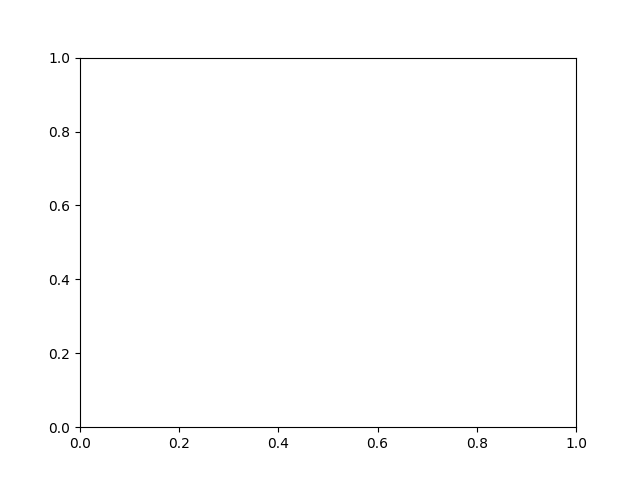

In [84]:
import matplotlib.dates
import matplotlib.pyplot as plt


dates = t_flux.tolist()
dates = matplotlib.dates.date2num(dates)

x = dates
y = flux

plt.close()
# Plotting flux vs. time
plt.plot(x, y, ".-")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
plt.gcf().autofmt_xdate()
# Adding converage line
plt.axvline(x=x[intersection_index], color="r", linestyle="--")
plt.show()


# # # Creating Flux v. Time plot
# layout = go.Layout(
#     title        = dict(text='$\\text{Flux}\:(\\Phi)\:\\text{vs. Time }(t)$',
#                         x=0.5),
#     xaxis_title  = '$t\:[days]$',
#     yaxis_title  = '$\\text{ Number of fragments passing XZ plane, }\Phi\:$',
#     template     = 'plotly_white'
# )


# data = [
#     go.Scatter(x=t_flux, y=flux,
#                mode='lines',
#                name='Flux'),
#     go.Scatter(x=[t_flux[intersection_index], t_flux[intersection_index]], y=[0, np.max(flux)],
#                mode='lines',
#                line=dict(dash = 'dash'),
#                name='Convergence')
# ]

# fig1 = go.Figure(data=data, layout=layout)

# # Stopping data to have half before intersection index and half after
# # index_stop = intersection_index * 2
# # if index_stop > len(flux) - 1 : index_stop = len(flux) - 1
# # fig1.update_layout(xaxis_range=[t_flux[0],t_flux[index_stop]])

# # # Saving plot as an image and uploading it to plotly
# # #fig1.write_image("figures/Flux_v_Time.png", width=500, height=500, scale=2)
# py.iplot(fig1, filename="Flux v. Time")

In [ ]:
# (N_t, 2, N_frag, 3))
pos = states_cartesian[:, 0, :, :]
np.linalg.norm(pos[:, 0, :], axis=1)

## 2.3 Band Formation

### 2.3.1 Drag Implementation

In [ ]:
import odap.Aerodynamics as aero
import numpy as np


upper_bound = 900  # [km]
altitudes = np.arange(0, upper_bound, 1)  # [km]
rho = aero.atmosphere_density(altitudes)  # [kg·m^-3]

I_standard = np.argwhere(altitudes == 25).flatten()[0]
I_cira = np.argwhere(altitudes == 500).flatten()[0]

# Plotting the Exponential Atmospheric Model

layout = go.Layout(
    title=go.layout.Title(text="Altitude (z) vs. Atmospheric Density (ρ)", x=0.5),
    xaxis_title="z [km]",
    yaxis_title="$\log_{10}(\\rho\:[kg·m^{-3}])$",
    template="plotly_white",
    legend=go.layout.Legend(yanchor="top", y=0.99, xanchor="right", x=0.99),
)

data = [
    go.Scatter(
        x=altitudes[:I_standard],
        y=rho[:I_standard],
        mode="lines",
        name="U.S Standard Atmosphere",
    ),
    go.Scatter(
        x=altitudes[I_standard:I_cira],
        y=rho[I_standard:I_cira],
        mode="lines",
        name="CIRA-72",
    ),
    go.Scatter(
        x=altitudes[I_cira:],
        y=rho[I_cira:],
        mode="lines",
        name="CIRA-72 with T_infinity = 1000K",
    ),
]

fig = go.Figure(data=data, layout=layout)
fig.update_yaxes(type="log")


# fig.write_image("figures/Atmospheric_Density_v_Altitude.png", width=500, height=500, scale=2)
f2 = go.FigureWidget(fig)
f2

### 2.3.1 Applying Perturbations to Satellite

In [ ]:
import odap.Aerodynamics as aero

op.tspan[-1] = 3600 * 24 * 25
op.dt = 3600 * 24
de, da, di, dOmega, domega, dnu, dp = op.propagate_perturbations()

# 3. Analysis

## 3.1 Flux

### 3.1.1 FLux plot

In [ ]:
# Creating Flux v. Time plot
layout = go.Layout(
    title=dict(text="$\\text{Flux}\:(\\Phi)\:\\text{vs. Time }(t)$", x=0.5),
    xaxis_title="$t\:[days]$",
    yaxis_title="$\\text{ Number of fragments passing XZ plane, }\Phi\:$",
    template="plotly_white",
)


data = [
    go.Scatter(x=t_flux, y=flux, mode="lines", name="Flux"),
    go.Scatter(
        x=[t_flux[intersection_index], t_flux[intersection_index]],
        y=[0, np.max(flux)],
        mode="lines",
        line=dict(dash="dash"),
        name="Convergence",
    ),
]

fig1 = go.Figure(data=data, layout=layout)

# Stopping data to have half before intersection index and half after
index_stop = intersection_index * 2
if index_stop > len(flux) - 1:
    index_stop = len(flux) - 1
fig1.update_layout(xaxis_range=[t_flux[0], t_flux[index_stop]])

# Saving plot as an image and uploading it to plotly
fig1.write_image("figures/Flux_v_Time.png", width=500, height=500, scale=2)
# py.iplot(fig1, filename="Flux v. Time")

### 3.1.2 Convergence Ratio plot

In [ ]:
# Creating Convergence Ratio v. Time plot
layout = go.Layout(
    title=dict(text="Convergence ratio vs. Time (t)", x=0.5),
    xaxis_title="$t\:[days]$",
    yaxis_title="Convergence ratio []",
    template="plotly_white",
    legend=go.layout.Legend(yanchor="top", y=0.99, xanchor="right", x=0.99),
)
data = [
    go.Scatter(x=t_flux, y=convergence_ratio, mode="lines", name="Convergence ratio"),
    go.Scatter(
        x=[t_flux[intersection_index], t_flux[intersection_index]],
        y=[0, np.max(flux)],
        mode="lines",
        line=dict(dash="dash"),
        name="Convergence time",
    ),
    go.Scatter(
        x=[t_flux[0], t_flux[-1]],
        y=[tol, tol],
        mode="lines",
        line=dict(dash="dash"),
        name="Tolerance",
    ),
]
fig2 = go.Figure(data=data, layout=layout)
fig2.update_yaxes(type="log")
fig2.write_image("figures/Convergence_Ratio_v_Time.png", width=500, height=500, scale=2)
# py.iplot(fig2, filename="Convergence Ratio v. Time")

## 3.2 Ring visualization

In [ ]:
import plotly.express as px
import plotly.io as pio
import pandas

spherical_earth_map = np.load("map_sphere.npy")

pos_toroid = cs_toroid[:, 0, :, :] / 1e3
N_timesteps = pos_toroid.shape[0]
N_fragments = pos_toroid.shape[1]
r_E = op.cb["radius"] / 1e3
xm, ym, zm = spherical_earth_map.T * r_E

# Converting data to pandas dataframe
df = pandas.DataFrame()
# *** Update this if chnage timestep in initial orbit propagation ***
dt = 60 * 5  # [s]
# Want to show the evolution in 30 min
timesteps = np.arange(0, N_timesteps, 6)

for t in timesteps:
    step = t * np.ones_like(N_timesteps)
    time = dt * step / 60  # [min]
    d = {
        "X": pos_toroid[t, :, 0],
        "Y": pos_toroid[t, :, 1],
        "Z": pos_toroid[t, :, 2],
        "Min.": time,
        "a": ks_toroid[t, 0, :] / 1e3,
        "e": ks_toroid[t, 1, :],
        "i": ks_toroid[t, 2, :],
    }
    df = pandas.concat([df, pandas.DataFrame(data=d)])

# Creating visual
def spheres(size, clr, dist=0):

    # Set up 100 points. First, do angles
    theta = np.linspace(0, 2 * np.pi, 100)
    phi = np.linspace(0, np.pi, 100)

    # Set up coordinates for points on the sphere
    x0 = dist + size * np.outer(np.cos(theta), np.sin(phi))
    y0 = size * np.outer(np.sin(theta), np.sin(phi))
    z0 = size * np.outer(np.ones(100), np.cos(phi))

    # Set up trace
    trace = go.Surface(x=x0, y=y0, z=z0, colorscale=[[0, clr], [1, clr]])
    trace.update(showscale=False)

    return trace


fig = px.scatter_3d(
    data_frame=df,
    x="X",
    y="Y",
    z="Z",
    title="Evolution of debris cloud to toroid formation",
    hover_data={
        "Min.": False,
        "X": False,
        "Y": False,
        "Z": False,
        "a": ":.1f",
        "e": ":.4f",
        "i": ":.1f",
    },
    height=800,  # height of graph in pixels
    width=800,
    animation_frame="Min.",  # assign marks to animation frames
    range_x=[-r_E - 1000, r_E + 1000],
    range_z=[-r_E - 1000, r_E + 1000],
    range_y=[-r_E - 1000, r_E + 1000],
)
fig.update_traces(marker={"size": 3})
# Add Earth
earth = spheres(r_E, "#F0FFFF", 0)  # Earth
# fig.add_trace(go.Scatter3d(x=xm, y=ym, z=zm, mode='lines', line=dict(color=zm, colorscale='Viridis')))
fig["layout"]["scene"]["aspectmode"] = "cube"
fig.add_trace(earth)
fig.update_layout(transition={"duration": 2000})
fig.write_html("plots/ring.html")

## 3.3 Band visualization

In [ ]:
temp = np.zeros_like(da)  # The params set to 0 dont matter for converting to rv
ks_propagated = np.swapaxes(
    np.stack([da, de, di, dOmega, domega, temp, dnu, dp, temp, temp]).T, 1, 2
)
ks_final = np.concatenate([ks_toroid, ks_propagated])
op.states = ks_final
cs_final = op.cartesian_representation()

In [ ]:
import pandas as pandas
import plotly.express as px

pos_toroid = cs_final[cs_toroid.shape[0] - 1 :, 0, :, :] / 1e3
N_timesteps = pos_toroid.shape[0]
N_fragments = pos_toroid.shape[1]
r_E = op.cb["radius"] / 1e3


# Converting data to pandas dataframe
df = pandas.DataFrame()
# *** Update this if chnage timestep in initial orbit propagation ***
dt = 60 * 5  # [s]
# Want to show the evolution in 1 day steps
timesteps = np.arange(0, N_timesteps, 5)

for t in timesteps:
    step = t * np.ones_like(N_timesteps)
    time = step  # [day]
    d = {
        "X": pos_toroid[t, :, 0],
        "Y": pos_toroid[t, :, 1],
        "Z": pos_toroid[t, :, 2],
        "Day": time,
    }
    df = pandas.concat([df, pandas.DataFrame(data=d)])


def spheres(size, clr, dist=0):

    # Set up 100 points. First, do angles
    theta = np.linspace(0, 2 * np.pi, 100)
    phi = np.linspace(0, np.pi, 100)

    # Set up coordinates for points on the sphere
    x0 = dist + size * np.outer(np.cos(theta), np.sin(phi))
    y0 = size * np.outer(np.sin(theta), np.sin(phi))
    z0 = size * np.outer(np.ones(100), np.cos(phi))

    # Set up trace
    trace = go.Surface(x=x0, y=y0, z=z0, colorscale=[[0, clr], [1, clr]])
    trace.update(showscale=False)

    return trace


fig = px.scatter_3d(
    data_frame=df,
    x="X",
    y="Y",
    z="Z",
    title="Evolution of debris cloud to Band formation",
    # labels={'Years in school (avg)': 'Years Women are in School'},
    # hover_data={'Min.': False, 'X': False, 'Y':False, 'Z':False, 'a':':.1f', 'e':':.4f','i':':.1f' },
    # hover_name='Orbital Elements',        # values appear in bold in the hover tooltip
    height=800,  # height of graph in pixels
    width=800,
    animation_frame="Day",  # assign marks to animation frames
    range_x=[-r_E - 1000, r_E + 1000],
    range_z=[-r_E - 1000, r_E + 1000],
    range_y=[-r_E - 1000, r_E + 1000],
)
fig.update_traces(marker={"size": 1.5, "color": "#6372f4"})
# Add Earth
earth = spheres(r_E, "#ffffff", 0)  # Earth
fig.add_trace(earth)
# fig.add_trace(go.Scatter3d(x=xm, y=ym, z=zm, mode='lines', line=dict(color=zm, colorscale='Viridis')))
fig["layout"]["scene"]["aspectmode"] = "cube"
fig.update_layout(transition={"duration": 2000})
fig.update_layout(paper_bgcolor="rgba(0,0,0,0)", plot_bgcolor="rgba(0,0,0,0)")
fig.write_html("plots/band.html")

## 3.4 Time to deorbit 

In [ ]:
import plotly.figure_factory as ff
import matplotlib.cm as cm

AM = op.A / op.M
z = (da * (1 - de)) - op.cb["radius"]
z[z < 100 * 1e3] = 0

layout = go.Layout(
    title=dict(text="Altitude of 50 debris fragments over 3 years", x=0.5),
    xaxis_title="$t\:[days]$",
    yaxis_title="Altitude [km]",
    template="plotly_white",
    legend=go.layout.Legend(yanchor="top", y=0.99, xanchor="right", x=0.99),
)

data = []

for i in range(25):
    alt = np.trim_zeros(z[i, :]) / 1e3
    scatter = go.Scatter(x=[i for i in range(len(alt))], y=alt, mode="lines")
    data.append(scatter)

fig = go.Figure(data=data, layout=layout)
fig.update_layout(coloraxis=dict(colorscale="RdBu"), showlegend=False)
fig.show()
fig.write_image("figures/oxp_altitudes.png", width=500, height=500, scale=2)

## 3.5 Debris spread

In [ ]:
index = int(np.ceil(ks_propagated.shape[0] * 0.10))  # index near begining
raan_0 = ks_propagated[index, 3, :].copy() % 360
raan_0[raan_0 > 180] -= 360  # Converting angles to new range

raan_mid = ks_propagated[ks_propagated.shape[0] // 2, 3, :].copy() % 360
raan_mid[raan_mid > 180] -= 360

raan_f = ks_propagated[-1, 3, :].copy() % 360
raan_f[raan_f > 180] -= 360

In [ ]:
import math
import plotly.figure_factory as ff

uniform_dist = np.random.uniform(-180, 180, len(raan_0))
group_labels = [
    "$\Omega_{initial}$",
    "$\Omega_{midpoint}$",
    "$\Omega_{final}$",
    "uniform",
]
fig = ff.create_distplot(
    [raan_0, raan_mid, raan_f, uniform_dist], group_labels, show_hist=False
)

# Updating the uniform curve to be dashed
index = np.argwhere(np.array([data.legendgroup for data in fig.data]) == "uniform")[0][
    0
]
fig.data[index].line = dict(color="red", width=2, dash="dash")

# Layout
fig.layout["title"] = dict(text="Longitude of the ascending node distribution", x=0.5)
fig.layout["xaxis_title"] = "$\Omega\:[deg]$"
fig.layout["yaxis_title"] = "Kernel density estimation"
fig.layout["template"] = "plotly_white"


fig.write_image("figures/oxp_dist.png", width=500, height=500, scale=2)
py.iplot(fig, filename="Longitude of the ascending node distribution")

# 4. Conclusion